# Phys 704 Final Project

 ##### Name: Michael Bouliane 
 ##### ID: 20801403

## Part 1: 2D Ising Model

### Introduction:
To begin, the Ising model hamiltonian is given by 
\begin{equation}
\tag{1}
H = -J\sum\limits_{\langle{i,j}\rangle}\sigma_i\sigma_j 
\end{equation}
where for the sake of this project the coupling constant, $J$ is 1. In 2D the sum over nearest neighbours involves summing over the 4 bonds at each site. To model this with monte carlo methods we use the Metropolis algorithm which works as follows:

1. Pick a site at random on the lattice and compute its energy by summing over the 4 NN bonds
2. Flip the spin and re-compute the energy
3. Examine the change in energy caused by the spin flip, if the configuration is lower in energy then accept the change.
4. If the configuration is higher in energy, examine its Boltzmann factor and compare with a randomly generated number, if the Boltzmann factor is larger than the random number, accept the change
5. Repeat 

A monte carlo step in this project is defined as attempting to flip all $N = L^2$ spins once. Estimations about thermodynamic properties can be made by tracking quantities over time and averaging them as follows:

\begin{equation}
\tag{2}
\langle A \rangle = \frac{1}{m}\sum\limits_{i}^{m} A_i
\end{equation}

Where $m$ is the number of samples taken of the variable $A$ (a more detailed examination of this can be found in the implementation section). The most meaningful variables to track are the total energy per spin $E$, the energy squared per spin $E^2$, the magnetization per spin $M$ which is the order parameter for this Ising model, and finally the magnetization squared per spin $M^2$. From these we can estimate the heat capacity $C_v$ and the magnetic susceptibility $\chi$, which can be used to extract the critical exponents for the system. 

### Implementation
This project was done in Python using the `numpy`, `matplotlib`, and `multiprocess` packages. An `IsingSystem` class was created, with an initialization function that creates a lattice of spins with values $\pm 1$ of size $L \times L$ at temperature $T$. 

The function `energy` takes in an argument `idx` which is a tuple of numbers representing a site on the 2D lattice. It determines the location of that site's nearest neighbours and uses their spin values to determine the energy of site `idx`.

This is used in the function `energy_per_site` which loops over the entire lattice, summing the energy of each site and then normalizing by the total lattice size. This is the least efficient part of the code since it involves nested for loops.

Computing the magnetization using `magnetization` simply sums over the whole lattice and normalizes by the total lattice size

The main monte carlo loop is contained in the function `metropolis`. This function has arguments for the total number of monte carlo `steps`, and the fraction of beginning monte carlo steps to discard, `accept_frac`. The main loop of this function is used to track the evolution of the system's energy and magnetization, and to perform the previously mentioned thermodynamic averaging. However due to the previously mentioned inefficiency of the `energy_per_site` function, evaluating the system's total energy at every monte carlo (MC) step would massively slow down the code at very little benefit. In addition, this would give measurements which were highly correlated with one another thus affecting the statistics of the measurements. To remedy this `energy_per_site` is called after every thousand MC steps. This gives enough data for good statistics, while keeping the program's run-time reasonable and reducing the correlation between system configurations for adjacent measurements. Thus $m$ in equation 2 is not the total number of MC steps, but rather the number of samples of the variable $A$ which were taken. Another technique used to increase performance was to use pre-generation of all of the random variables needed for the calculations. The variable `idxs` is a randomly generated array of lattice sites, and `probs` are the randomly generated numbers which are then compared with the boltzmann factor. In the main loop, the relevant value can then be extracted from each of these arrays and then used in the required calculations. This is done because calling each of the relevant generation functions once to get all of the values is more efficient than calling the random generation function at each iteration of the loop. 

Finally, the function `heat_cycle` sets a range of `temps` at which to perform the `metropolis` function, using simulated annealing and returning the relevant variables as they evolve in temperature. 

This is all combined in the function `finite_scale`, which takes an argument `L` and uses it to generate an `IsingSystem` object of size `L`. The `heat_cycle` method is then called and the results are returned. This function is used to examine the finite size scaling effects of the magnetic susceptibility. Since the lattices which are examined are completely uncorrelated, we can perform this part of the calculation in parallel and compute the `heat_cycle` data for each lattice simultaneously, giving a massive performance increase.

In [88]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocess as mp

font = {'size': 10}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

class IsingSystem():
    def __init__(self,T=1.,L=5):
        '''Initializes an Ising lattice of size LxL with reciprocal temperature T'''
        
        self.temp = T
        self.lattice_size = L

        self.lattice = np.random.choice((-1,1), size=(self.lattice_size, self.lattice_size))
    
    def energy(self,idx):
        '''Computes the energy of a single spin site at given location
        
        Args:
        idx: Site index of spin

        Returns:
        E: Energy of site computed with Ising hamiltonian'''

        site = self.lattice[idx]

        left = (idx[0], idx[1]-1)
        right = (idx[0], (idx[1]+1)%self.lattice_size)
        top = (idx[0]-1, idx[1])
        bottom = ((idx[0]+1)%self.lattice_size, idx[1])

        E = -site*sum((self.lattice[left], self.lattice[right], self.lattice[top], self.lattice[bottom]))
        
        return(E)

    def magnetization(self):
        '''Computes magnetization per spin
        Returns: 
        M: Absolute value of magnetization'''
        
        M = np.sum(self.lattice)
        M /= self.lattice_size**2

        return(abs(M))
    
    def energy_per_site(self):
        '''Computes the energy per spin by evaluating the Ising Hamiltonian
        
        Returns:
        E: Total system energy per spin'''

        E = 0.

        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                E += self.energy((i,j))
        
        E /= self.lattice_size**2

        return(E)

    def metropolis(self, steps, accept_frac):
        '''The main Monte Carlo loop function
        
        Args:
        steps: The number of times to attempt to flip all N lattice spins
        accept_frac: Fraction of steps to discard before thermodynamic averaging
        
        Returns:
        energy_array: System energy per spin at different MC times
        energy: Thermodynamic average system energy per spin
        energy2: Average of system energy squared
        mag_array: Magnetization per spin at different MC times
        mag: Average of system magnetization per spin
        mag2: Average of system magnetization per spin squared'''

        steps = int(steps)*self.lattice_size**2 
        accept_steps = int(accept_frac*steps)
                
        idxs = np.random.randint(0,self.lattice_size,(steps,2)) #random sites for spin flips
        probs = np.random.random(size=steps) #array of acceptance probabilities

        energy_array = []
        energy = 0.
        energy2 = 0.
        ei = 0.

        mag_array = []
        mag = 0.
        mag2 = 0.
        mi = 0.

        n = 0
        i_array = [] 

        for i in range(steps):
            idx = tuple(idxs[i,:])
            energy_init = self.energy(idx)
            energy_final = -energy_init

            dE = energy_final-energy_init

            # if final state is lower in energy, accept the spin flip
            if dE <= 0: 
                self.lattice[idx] = -self.lattice[idx]

            else:
                boltz_fact = np.exp(-dE/self.temp) #boltzmann weight of energy difference

                # accept the spin flip that increases energy if boltzmann weight > acceptance prob
                if probs[i]<boltz_fact:
                    self.lattice[idx] = -self.lattice[idx]

                if i % 1000 == 0:
                    ei = self.energy_per_site()
                    mi = self.magnetization()

                    energy_array.append(ei)
                    mag_array.append(mi)
                    i_array.append(i)


                    if i >= accept_steps:
                        energy += ei
                        energy2 += ei*ei

                        mag += mi
                        mag2 += mi*mi

                        n += 1

        return(np.array([i_array, energy_array]),
            energy/n,
            energy2/n,
            np.array([i_array, mag_array]),
            mag/n,
            mag2/n)

    
    def heat_cycle(self, steps, frac):
        '''Performs the metropolis function over a range of temperatures from 1 to 4 with simulated annealing
        
        Args:
        steps: Number of MC steps to perform in metropolis algorithm
        frac: discard fraction

        Returns:
        energy: <E>
        energy2: <E^2>
        mag: <M>
        mag2: <M^2>
        temps: temperature array
        '''
        
        temps = np.flip(np.concatenate((np.linspace(1, 2, 10), np.linspace(2, 3, 30), np.linspace(3, 4, 10))))
        
        energy = np.zeros(50)
        energy2 = np.zeros(50)

        mag = np.zeros(50)
        mag2 = np.zeros(50)

        for T in range(50):
            self.temp = temps[T]
            _, energy[T], energy2[T], _, mag[T], mag2[T] = self.metropolis(steps, frac)
        
        return(energy, energy2, mag, mag2, temps)    

### Part A: $E$ and $M$ Over Time

Here we examine the results of running the `metropolis` function for $1\times 10^6$ MC steps at temperatures of 1 and 1/3. In general we expect the system to start in a random configuration with some $E>E_{gs}$ and $M \approx 0$. As the system evolves the energy should decrease and the magnetization should increase before fluctuating around their equilibrium values. We can determine what these values should be using the following arguments, first for the energy:

The 2D ising model ground state for $J=1$ is a ferromagnet, with all spins aligned. This means that $\sigma_i \sigma_j = 1$ if $i,j$ are NN. This means that the hamiltonian can be expressed as:

\begin{equation}
\tag{3}
H = -\sum\limits_{\langle i,j \rangle} 1
\end{equation}

Or equivalently, we can sum over lattice sites rather than NN bonds:

\begin{equation}
\tag{4}
H = \sum\limits_i \epsilon_i 
\end{equation}

Where $\epsilon_i$ is the energy of site $i$. Since each site has 4 NN and they are all spin aligned we have that $\epsilon_i = -4$. So finally we see that:

\begin{equation}
\tag{5}
H = -\sum\limits_i 4 \implies \frac{H}{N} = -4
\end{equation}

So we should expect that the system's energy will fluctuate around -4 after it has equilibrated. This is assuming that the system is able to reach its ground state, which may not be true if the temperature used is low enough to freeze in defects.

Using a very similar argument, we expect that $\frac{|M|}{N} = 1$ is the value about which the magnetization fluctuates. 

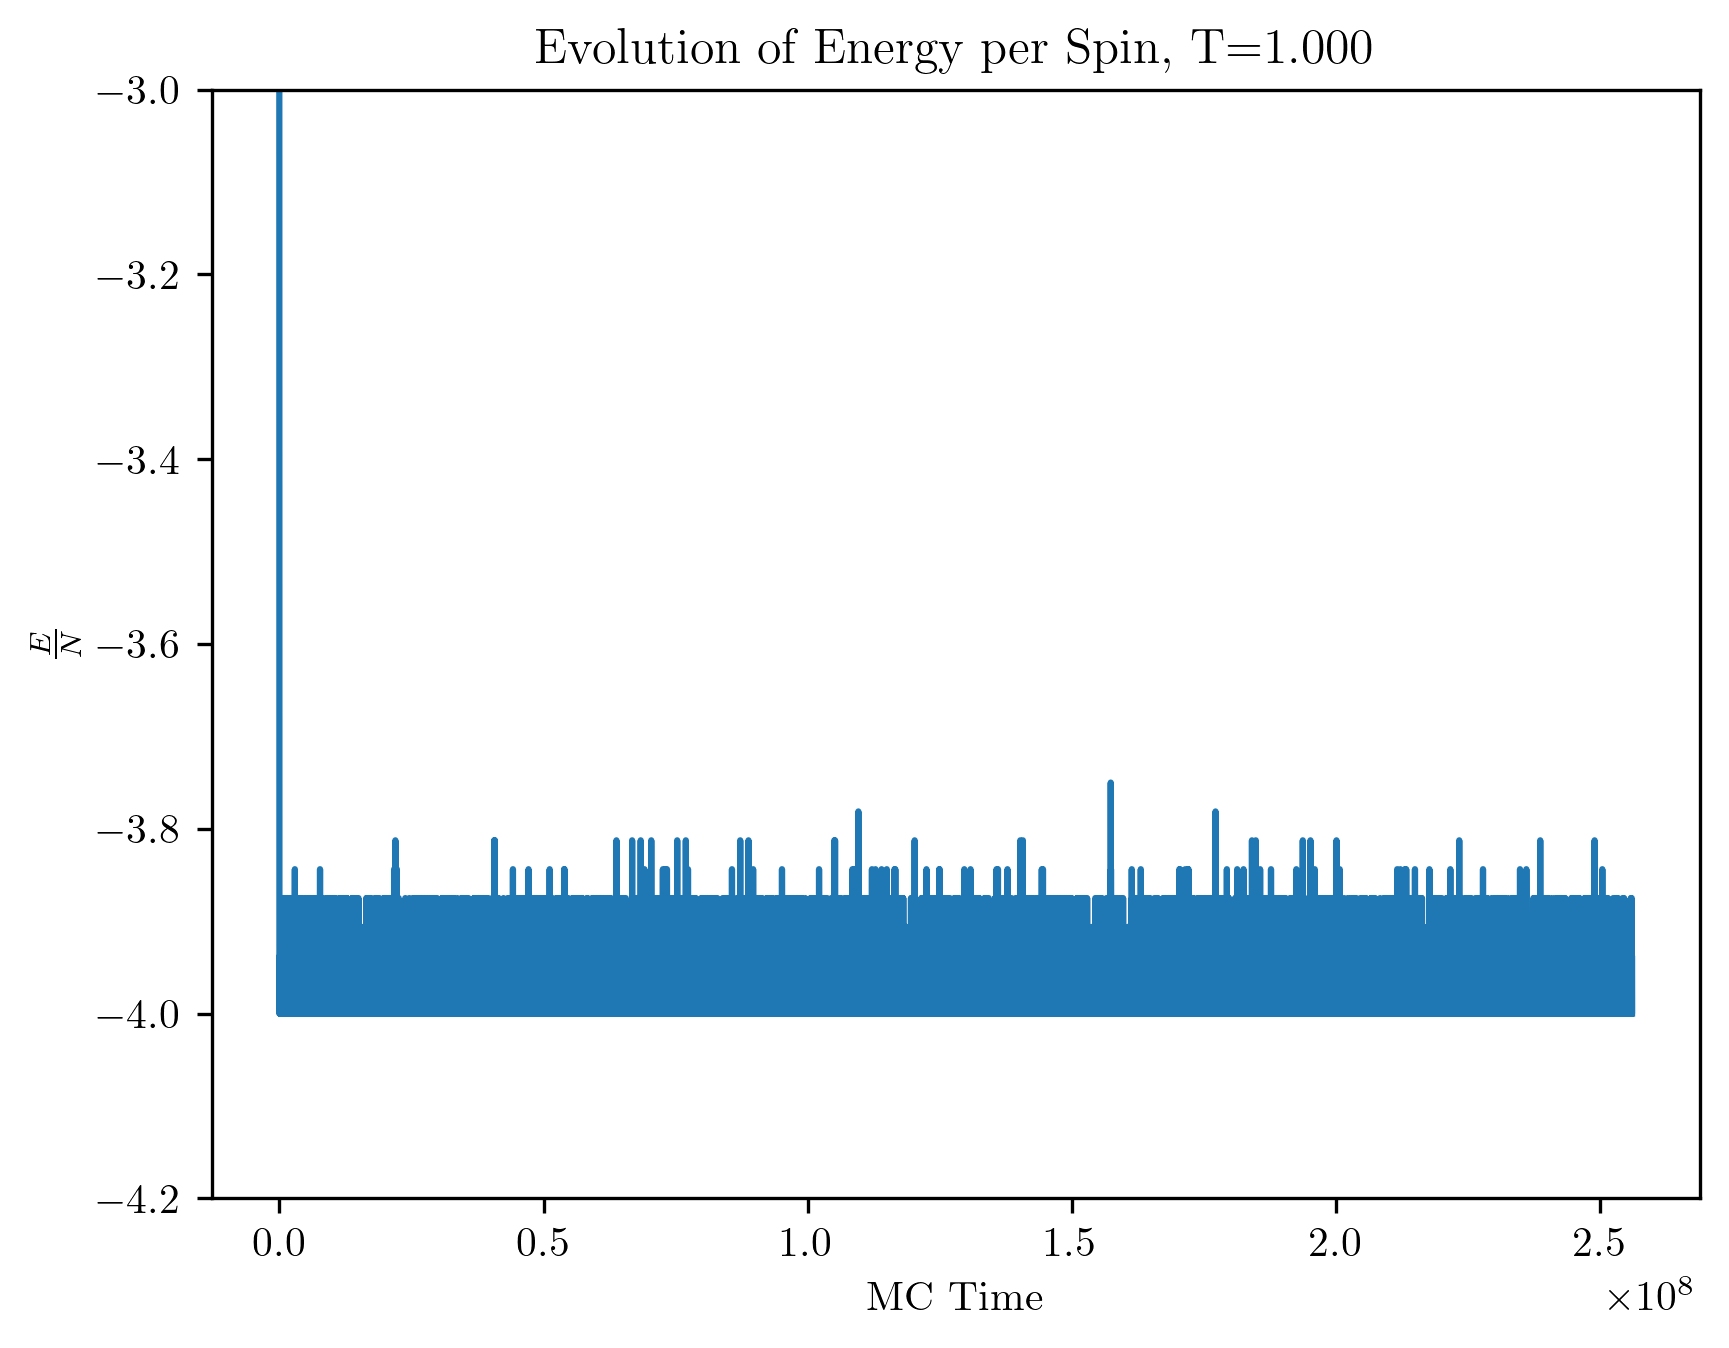

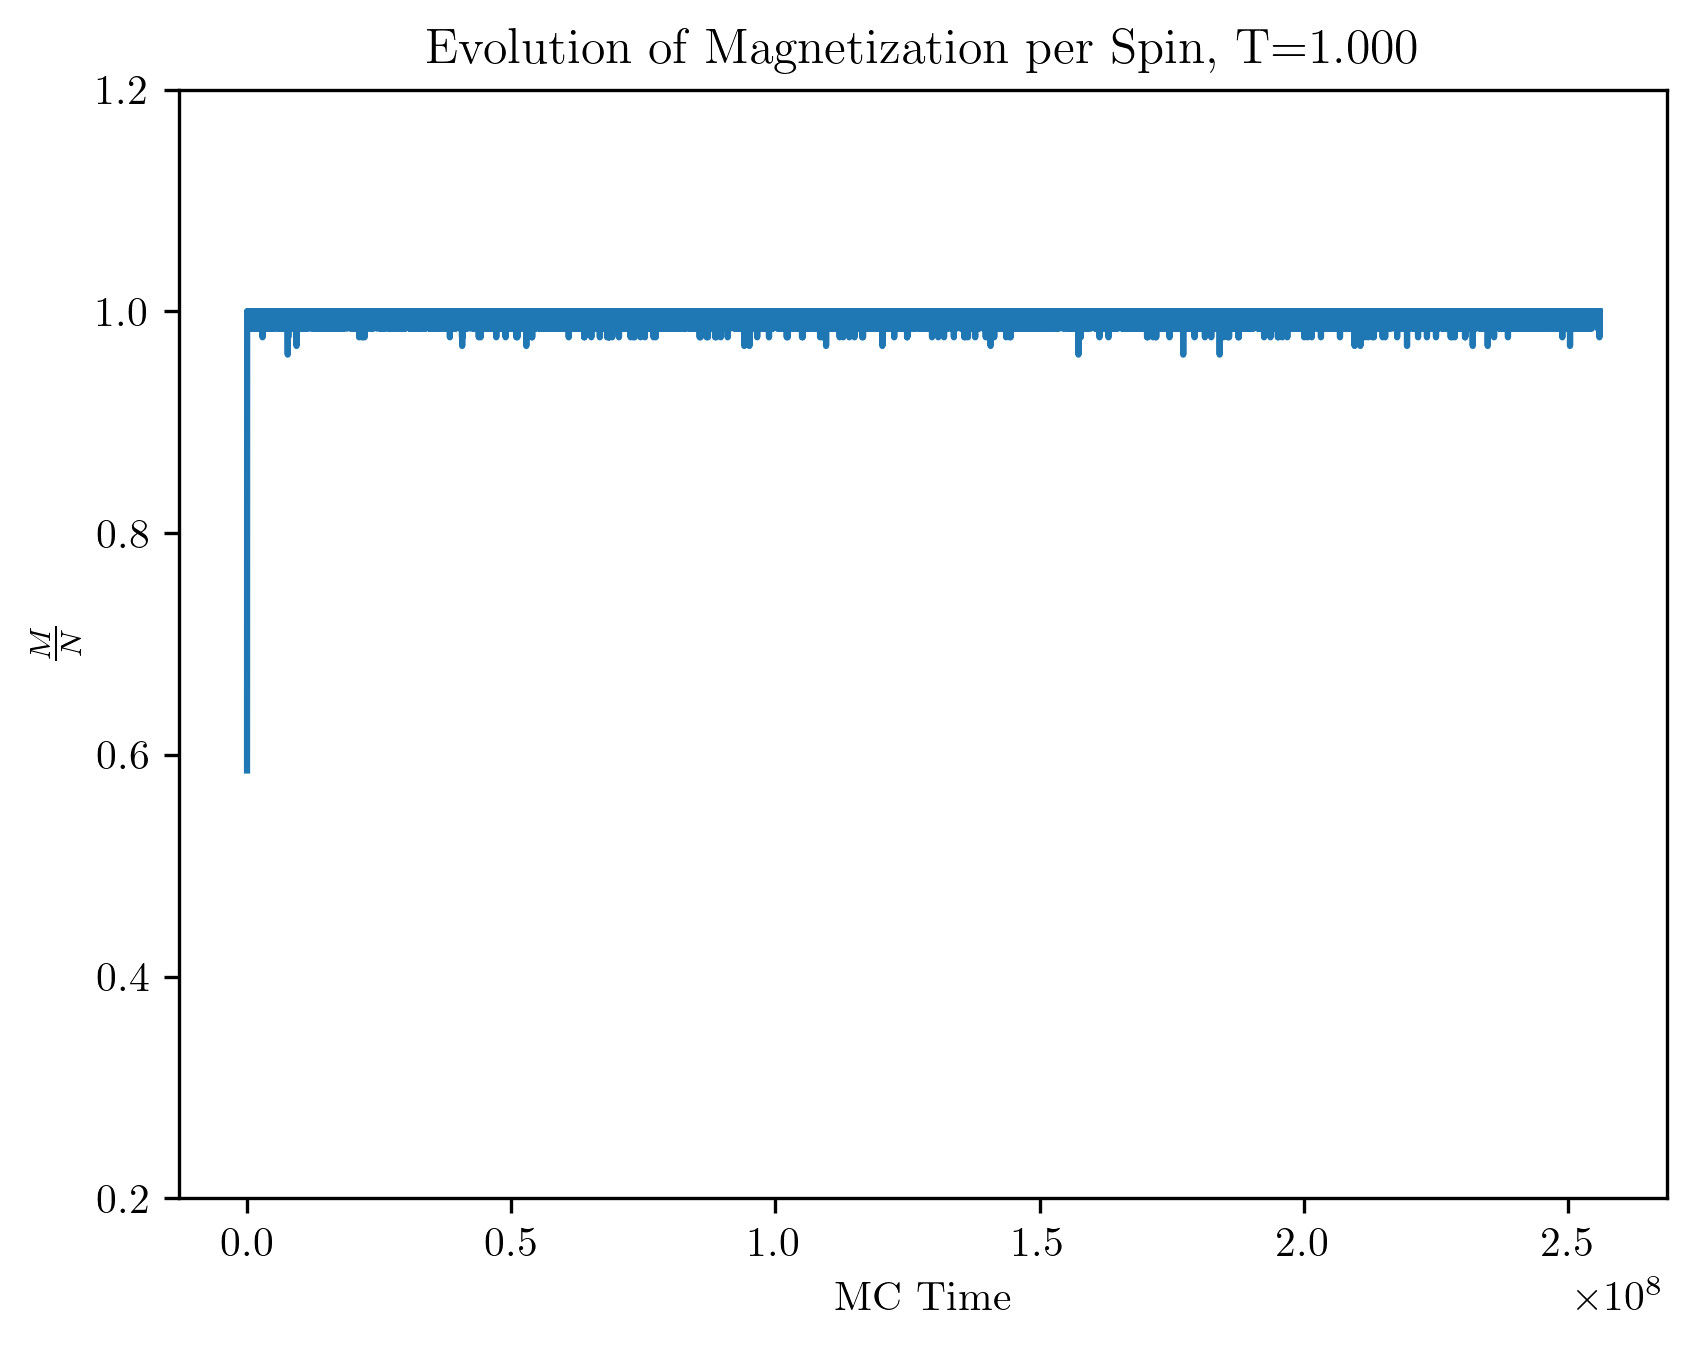

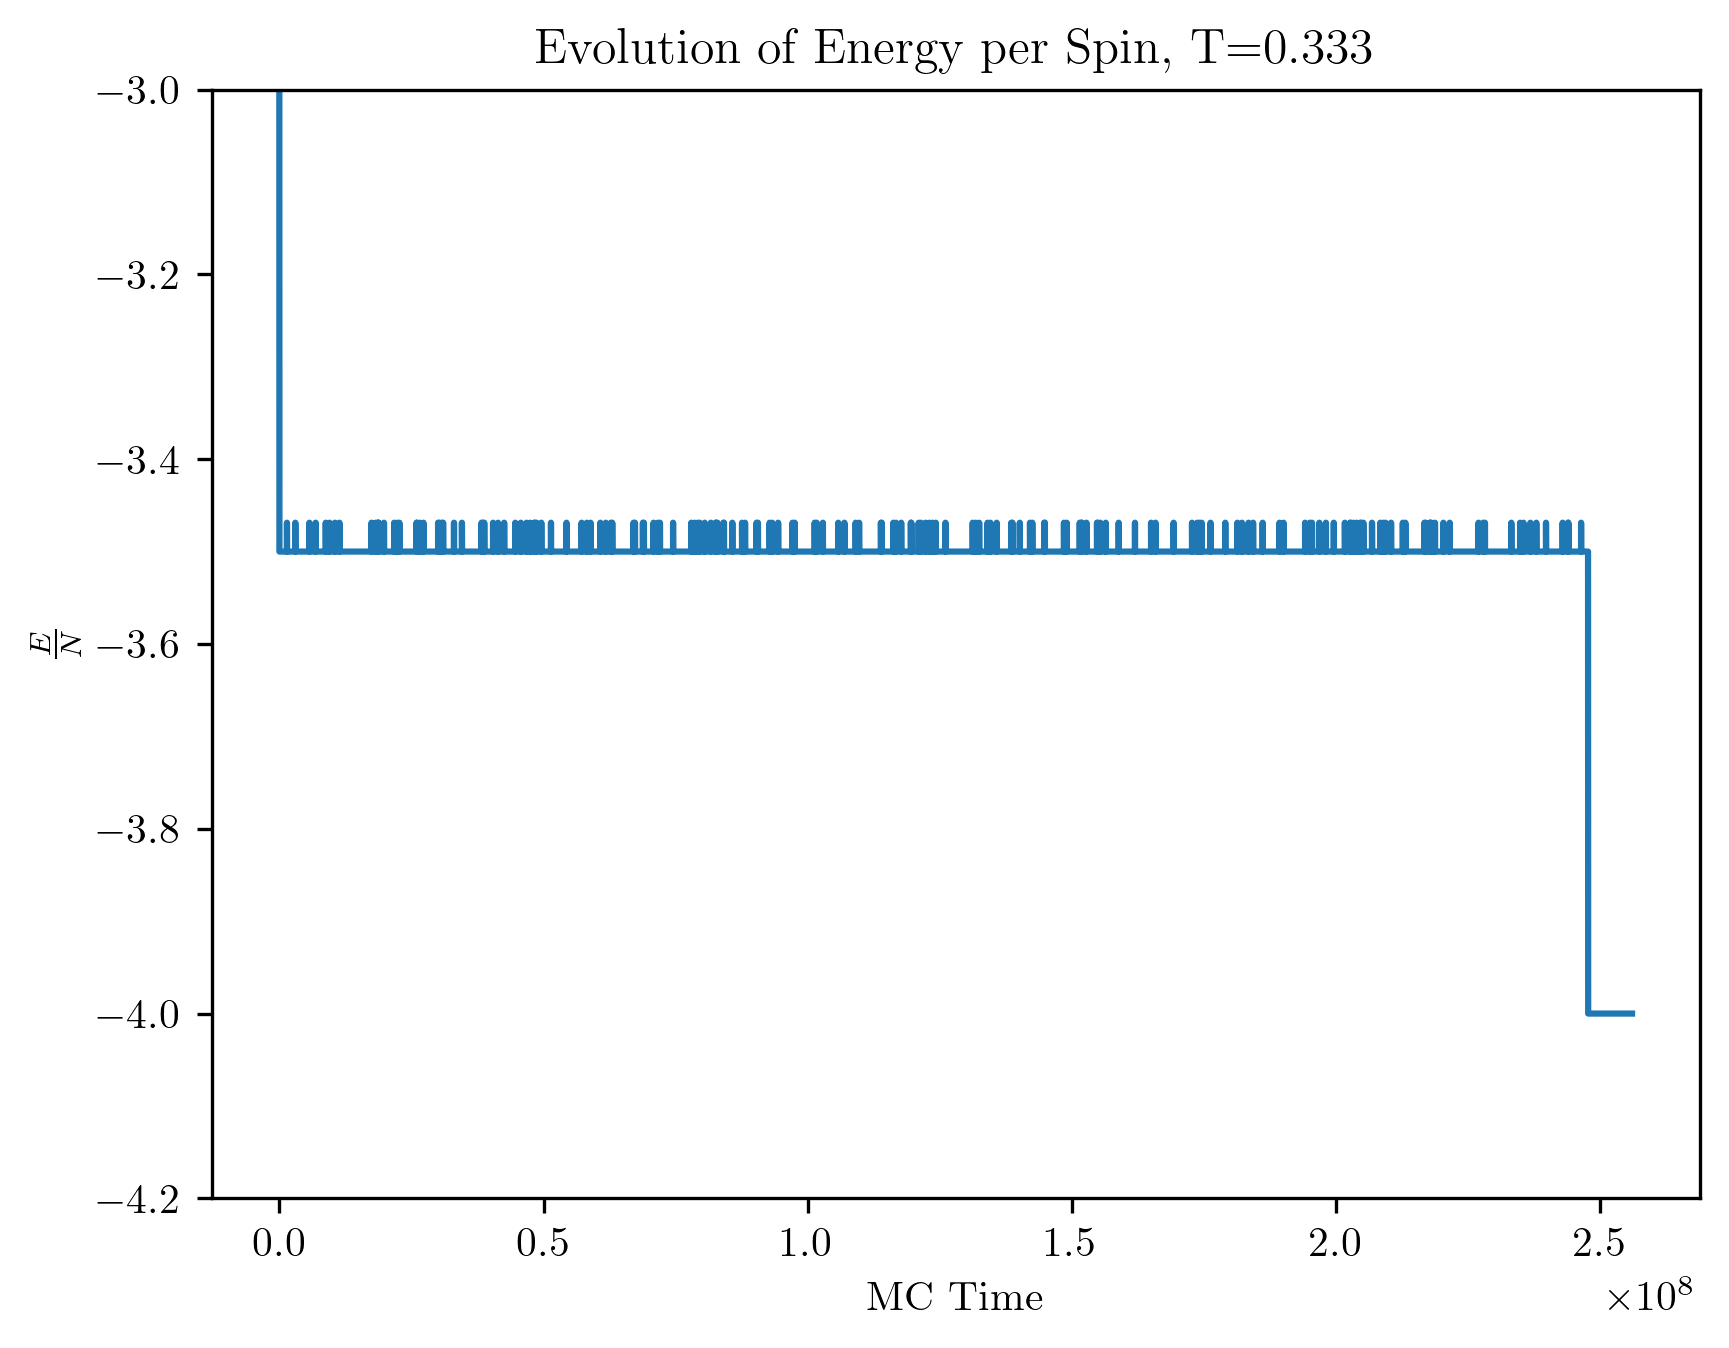

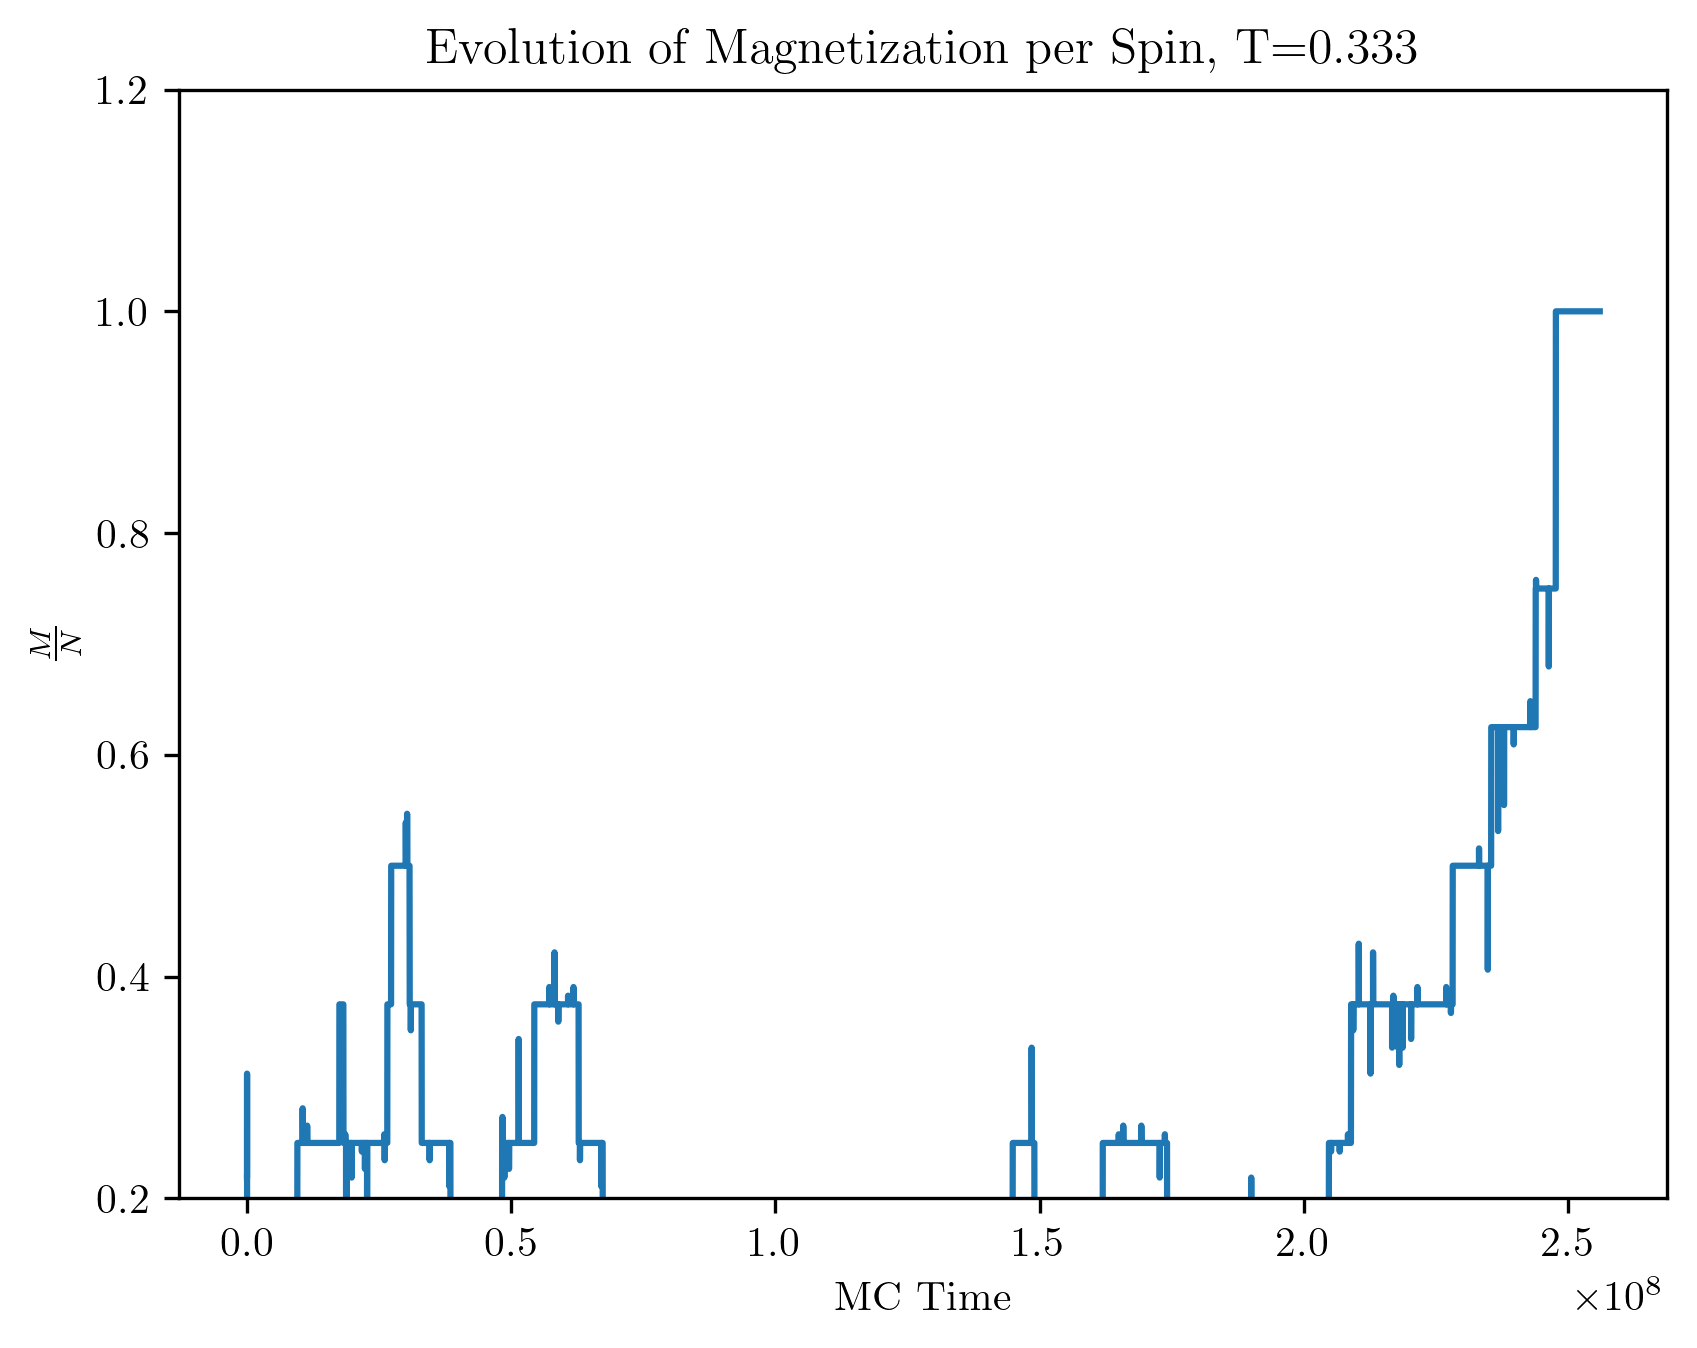

In [2]:
def partA(T):

    sys = IsingSystem(T, 16)

    energy, _, _, mag, _, _ = sys.metropolis(1e6, 0.1)
    
    plt.plot(energy[0], energy[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{E}{N}$")
    plt.title("Evolution of Energy per Spin, T={%.3f}"%T)
    plt.ylim(-4.2, -3)
    plt.show()

    plt.plot(mag[0], mag[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{M}{N}$")
    plt.title("Evolution of Magnetization per Spin, T={%.3f}"%T)
    plt.ylim(0.2, 1.2)
    plt.show()

partA(1)
partA(1/3)

At temperature $T=1$ we find that the energy starts at some value greater than the ground state energy before quickly settling in its lowest energy configuration. Both the energy per spin and magnetization per spin align with what we predicted, and we can see that truncating the first 10% of the data leaves us with more than enough to get good statistics.

More interesting is the case of $T=1/3$, which we can see gets stuck in a local minimum for a significant amount of time. This is the disadvantage of using the metropolis algorithm without simulated annealing, as the decreased Boltzmann factor makes it harder to accept spin flips which would kick the system out of a local minimum, which is the only way for it to reach the ground state. This lower acceptance rate does have benefits however, in that it reduces the fluctuations about the equilibrium value compared to higher temperatures. 

From these plots we can conclude that the metropolis algorithm is functioning exactly as intended. 

### Running the Algorithm

Four system sizes of $L=12, 16, 20, 24$ were simultaneously run through the `heat_cycle` function to examine how $\langle E \rangle, \langle E^2 \rangle, \langle M \rangle, \langle M^2 \rangle$ evolve with temperature. Using $10^6$ MC steps the code took an outrageously long time to run (thanks Python...). The results are examined below.

In [3]:
global finite_scale
def finite_scale(L):
    return([IsingSystem(1, L).heat_cycle(1e6, 0.1)])

Ls = [12, 16, 20, 24]
pool = mp.Pool(4) 
results = pool.map(finite_scale, Ls)
pool.close()

In [96]:
L12E = results[0][0][0]
L12E2 = results[0][0][1]
L12M = results[0][0][2]
L12M2 = results[0][0][3]

L16E = results[1][0][0]
L16E2 = results[1][0][1]
L16M = results[1][0][2]
L16M2 = results[1][0][3]

L20E = results[2][0][0]
L20E2 = results[2][0][1]
L20M = results[2][0][2]
L20M2 = results[2][0][3]

L24E = results[3][0][0]
L24E2 = results[3][0][1]
L24M = results[3][0][2]
L24M2 = results[3][0][3]

temps = results[0][0][4]

### Part B: $\langle E \rangle$ and $\langle M \rangle$ vs $T$

For a system size of $L=16$ we examine how the expectation values of $E$ and $M$ evolve with temperature starting at $T=4$ and cooling slowly to $T=1$.

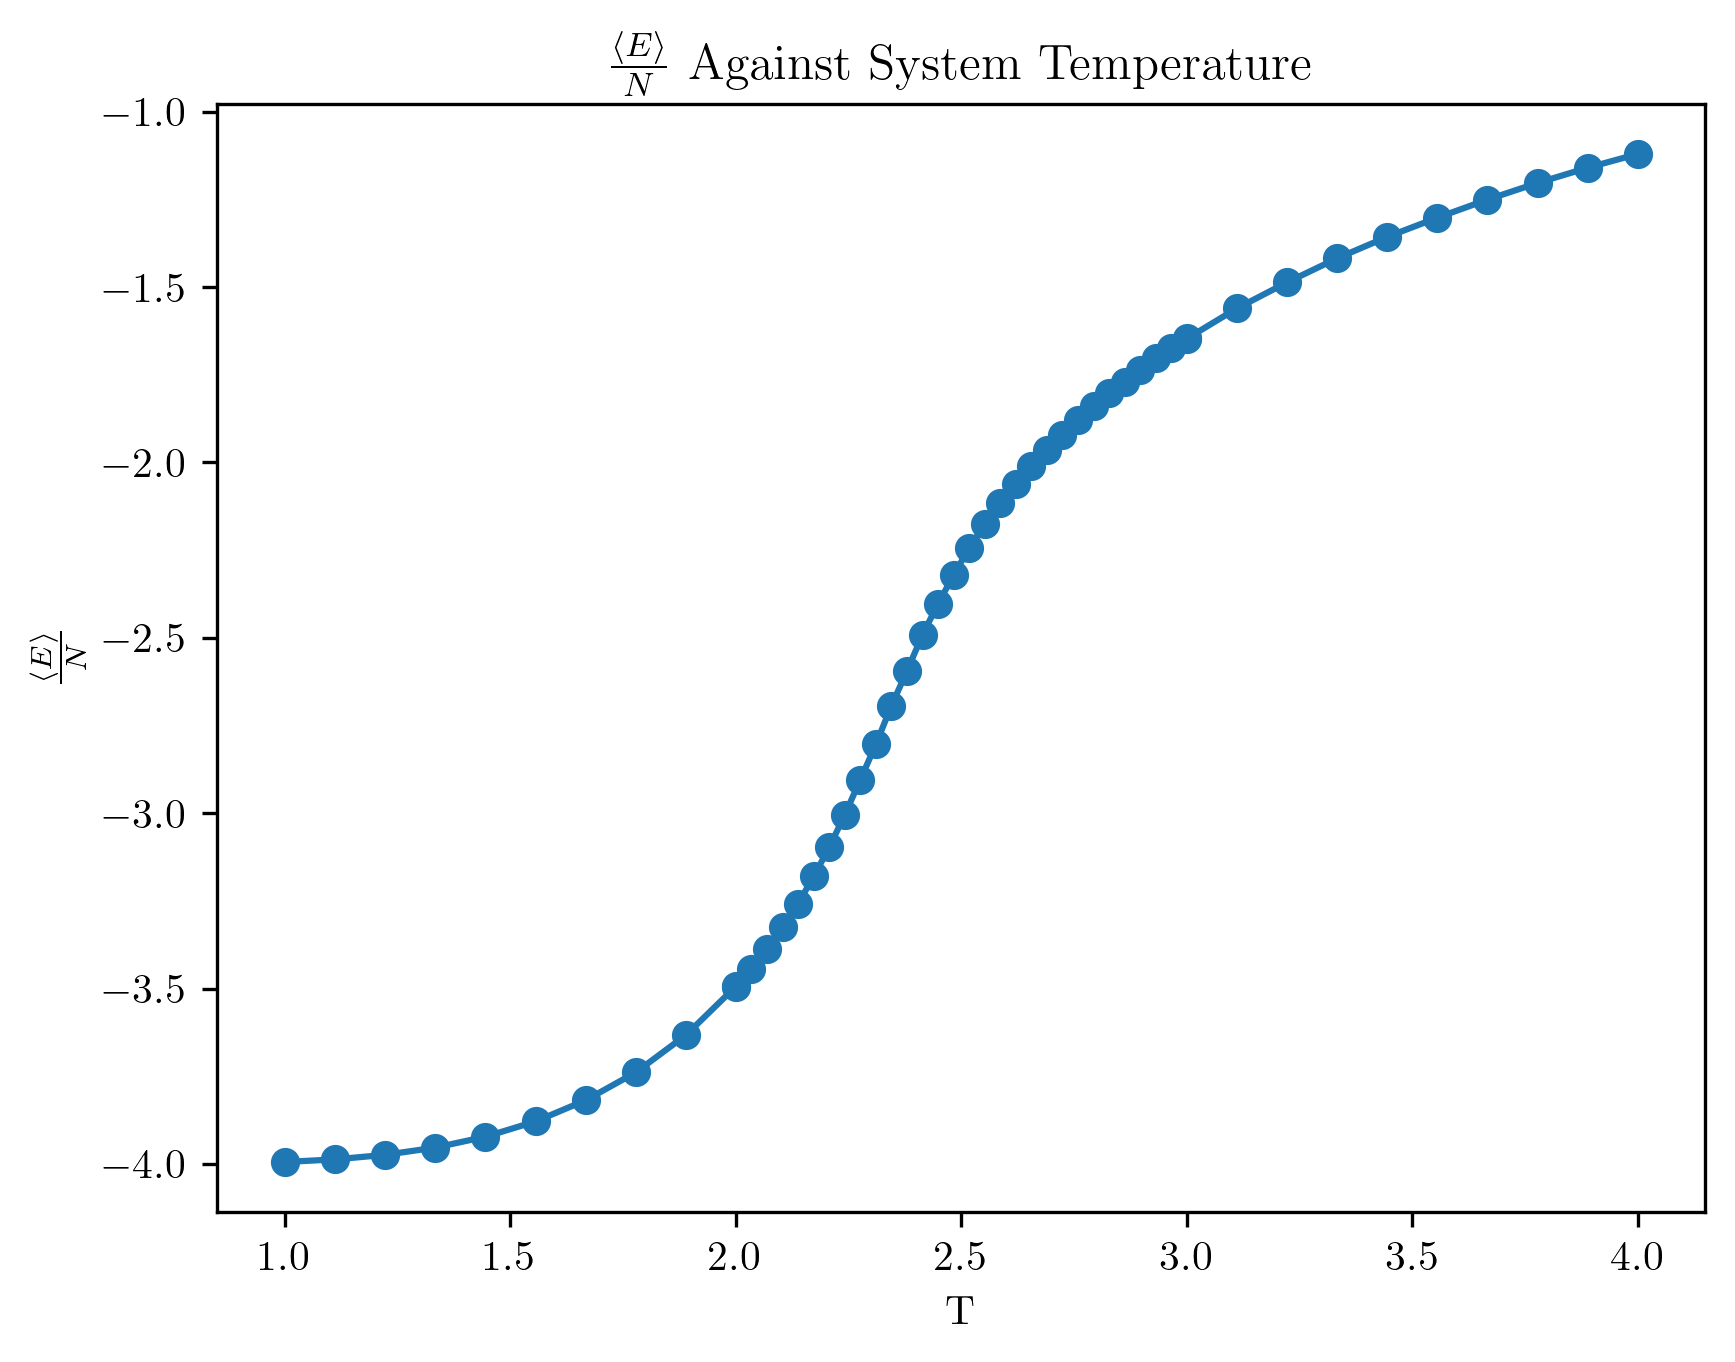

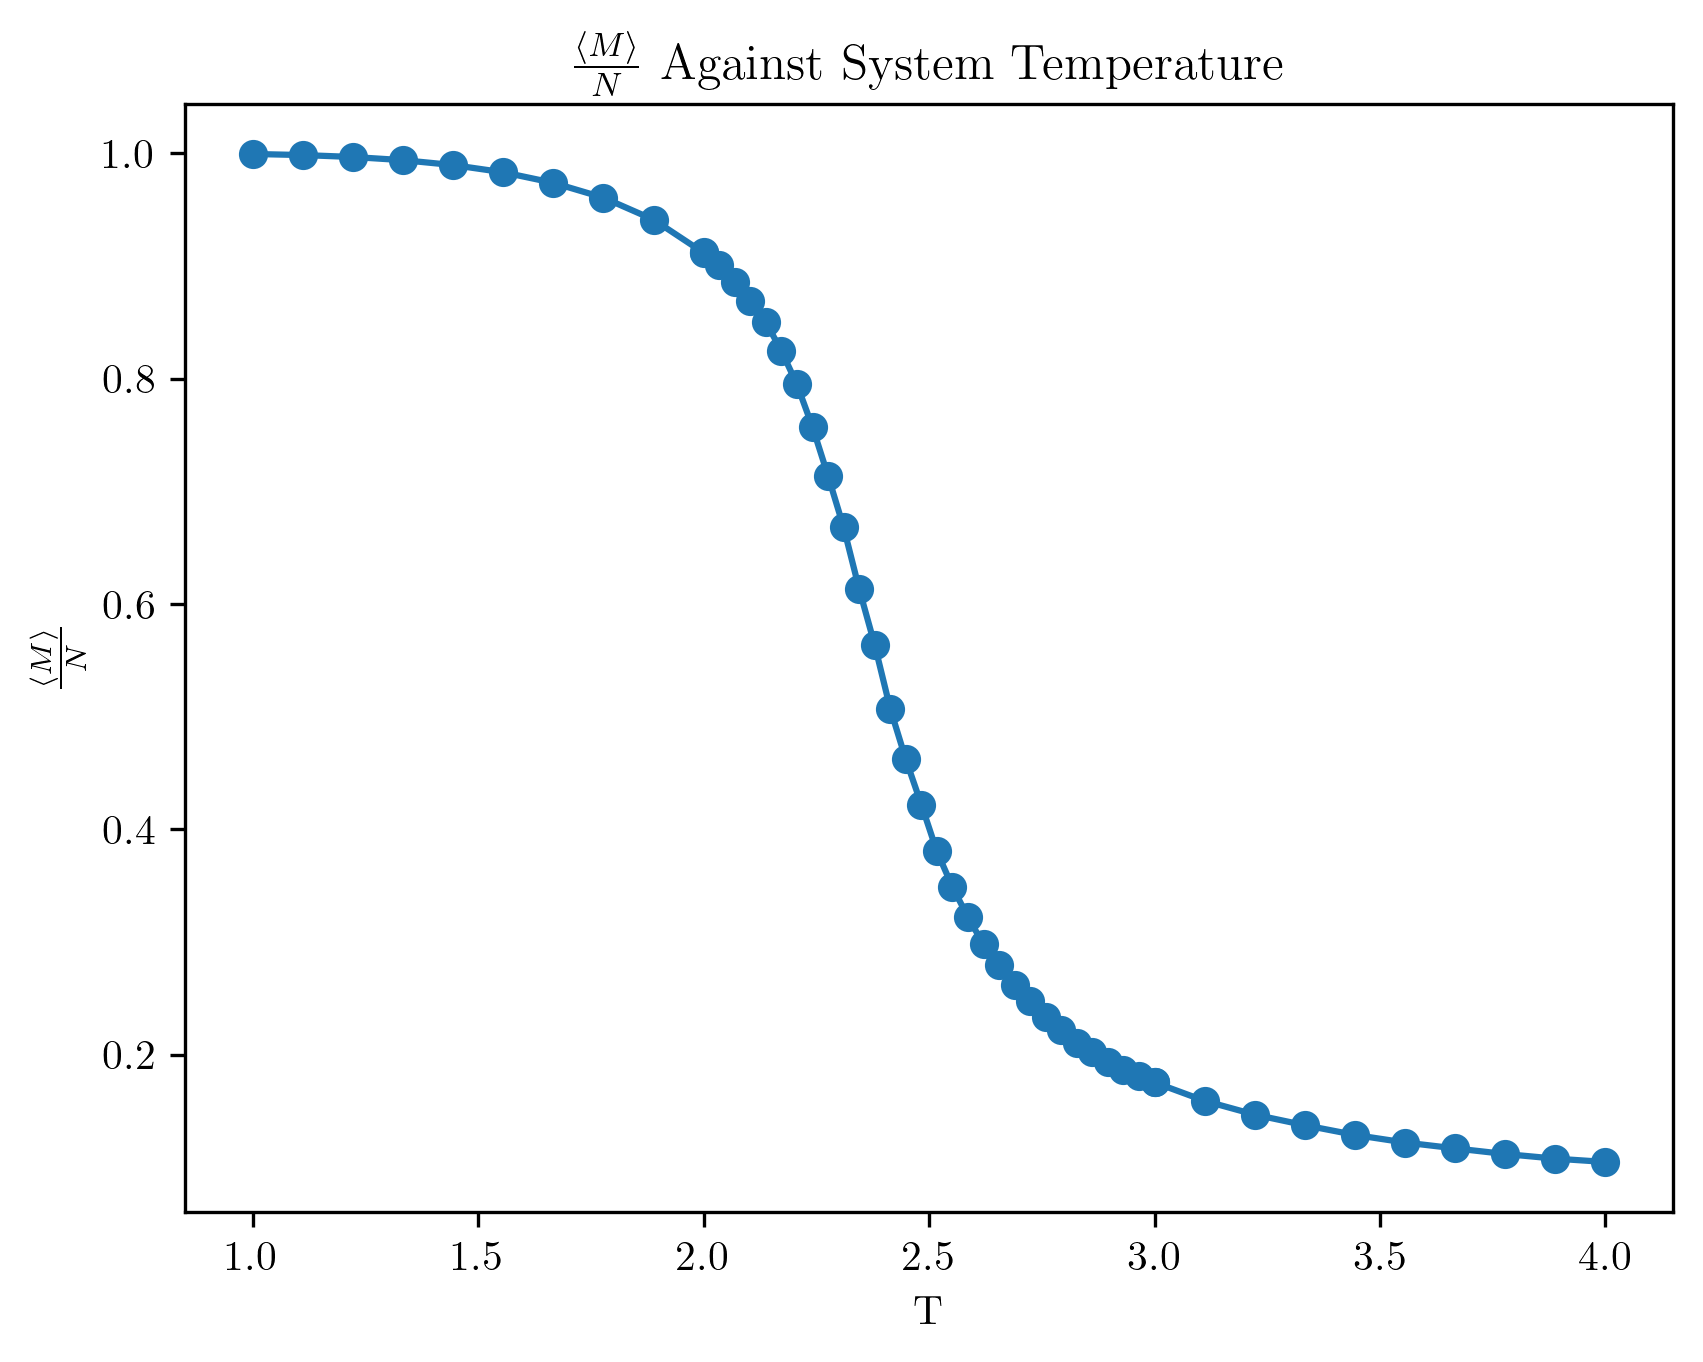

In [97]:
plt.plot(temps, L16E)
plt.scatter(temps, L16E)
plt.title(r"$\frac{\langle E \rangle}{N}$ Against System Temperature")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle E \rangle}{N}$")
plt.show()

plt.plot(temps, L16M)
plt.scatter(temps, L16M)
plt.title(r"$\frac{\langle M \rangle}{N}$ Against System Temperature")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle M \rangle}{N}$")
plt.show()

We expect that as $T\rightarrow0$ the magnetization should tend to 1 and the energy should approach -4 and that for $T\rightarrow\infty$ the magnetization tends to 0 while the energy should tend upwards. This is exactly what we obtain in the above plots. Since we allowed the system to sit so long in equilibrium ($10^6$ MC steps), and cooled slowly through the transition the measurements have very little noise and closely align with theory. 

The biggest determining factor in obtaining good results is the length of time the simulation is run for, using too few MC steps allows for the oscillations about the equilibrium value to have a greater impact on the mean value. Consider expressing the average energy as:

\begin{equation}
\tag{6}
\langle E \rangle = \frac{1}{m} \sum\limits_{i} (\bar{E} + \delta E_i) = \bar{E} + \frac{1}{m} \sum\limits_{i} \delta E_i
\end{equation}

If the fluctuations $\delta E_i$ are small, then the deviation of $\langle E \rangle$ from $\bar{E}$ decreases for an increasing number of MC steps. This is then further aided by sampling at many temperatures, with a greater density of data through the transition temperature.

### Part C: Heat Capacity and Estimation of $T_c$

First a derivation of $C_v$ in terms of $\langle E \rangle$ and $\langle E^2 \rangle$ will be given.

Starting from the definition of the expectation value of $E$ we have:
\begin{equation}
\tag{7}
\langle E \rangle = \frac{1}{Z}\sum\limits_i E_i\text{e}^{-\beta E_i} = -\frac{1}{Z}\frac{\partial Z}{\partial \beta}
\end{equation}

Next we look at the definition of the expectation value of the heat capacity:

\begin{equation}
\tag{8}
C_v = \frac{\partial \langle E \rangle}{\partial T} = \frac{\partial \langle E \rangle}{\partial \beta}\frac{\partial \beta}{\partial T}
\end{equation}

Substituting in the result from equation 7 and applying the chain rule we have:

\begin{equation}
\tag{9}
C_v = -\frac{1}{T^2}\left(\frac{1}{Z^2}\left(\frac{\partial Z}{\partial \beta}\right)^2 - \frac{1}{Z}\frac{\partial^2 Z}{\partial \beta^2}\right)
\end{equation}

Next we note that:

\begin{equation}
\tag{10}
\frac{\partial^2 Z}{\partial \beta^2} = \sum\limits_i E_i^2 \text{e}^{-\beta E_i} \implies \frac{1}{Z}\frac{\partial^2 Z}{\partial \beta^2} = \langle E^2\rangle
\end{equation}

Putting this all together we finally have that:

\begin{equation}
\tag{11}
C_v = \frac{1}{T^2}\left(\langle E^2\rangle - \langle E \rangle^2 \right)
\end{equation}

The heat capacity data for the $L=16$ lattice is presented below:

In [98]:
Cv16 = 1/temps**2 * (L16E2 - L16E**2)

Cvmax = max(Cv16)

Tc_est = temps[np.where(Cv16 == Cvmax)][0]
Tc_act = 2/np.log(1+np.sqrt(2))

pdif = float(100*abs(Tc_act-Tc_est)/Tc_act)

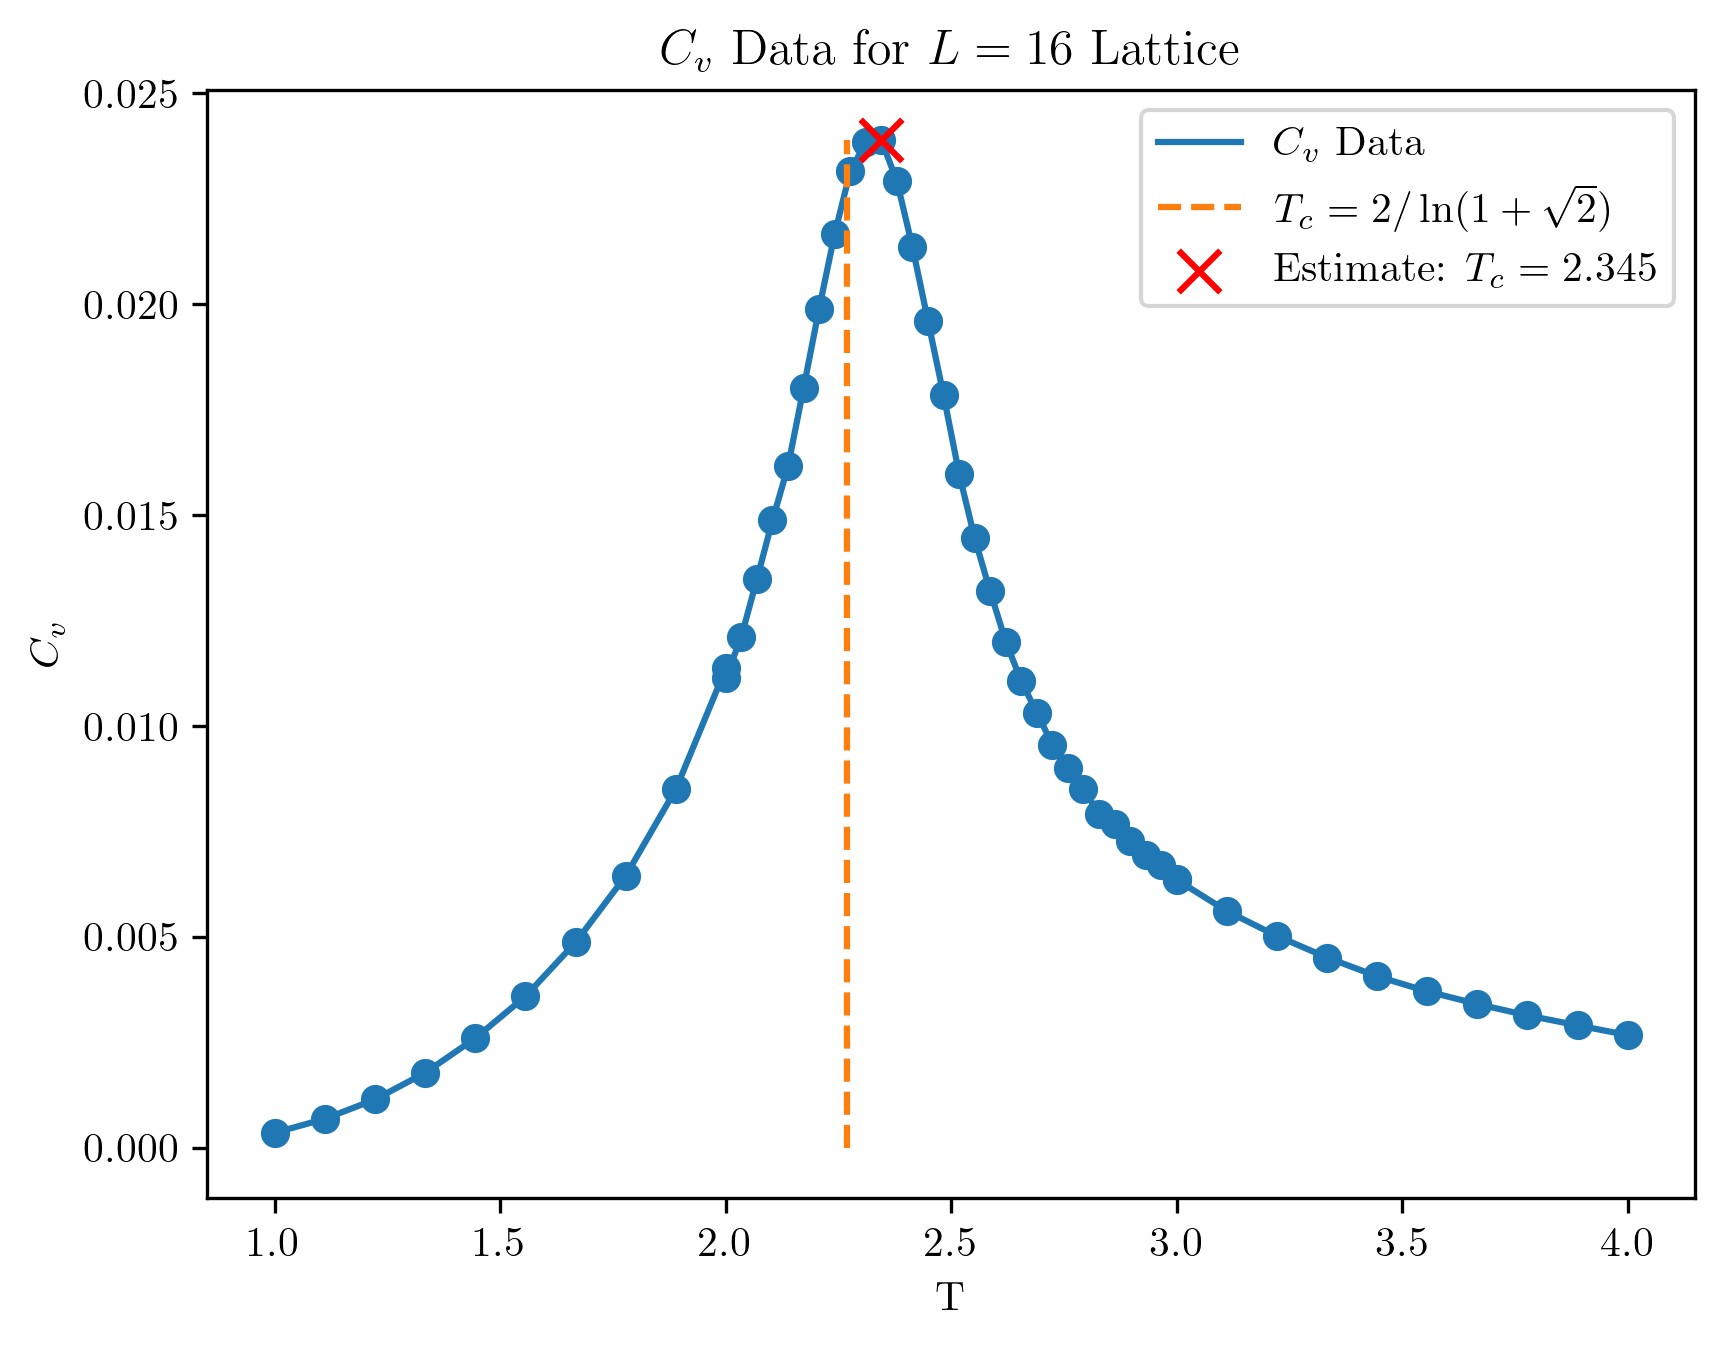

Estimate of Tc: 2.345
Error in estimate: 3.3%


In [99]:
plt.plot(temps, Cv16, label=r"$C_v$ Data")
plt.scatter(temps, Cv16)
plt.plot([Tc_act, Tc_act], [0, Cvmax], '--', label=r"$T_c = 2/\ln(1+\sqrt{2})$")
plt.scatter(Tc, Cvmax, marker='x', s=100, c='red', zorder=2.5, label=r'Estimate: $T_c={%.3f}$'%Tc)
plt.title(r'$C_v$ Data for $L=16$ Lattice')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

print("Estimate of Tc: %.3f"%Tc)

print("Error in estimate: %.1f"%pdif + "%")

From this we find that out estimate of the critical temperature is 2.345, which compared to the actual value of $Tc$ differs by just 3.3%. The small size of the system, with just 256 lattice sites, is easily the largest contributor to the error in our estimate. We know that there are no true phase transitions at finite sized systems, and that the further we are from the thermodynamic limit the less defined the phase transition point will be. Increasing the system size is easy in principle, but would mean a considerably larger computation time with little benefit. 

A more feasible solution is to use a larger density of points around the transition temperature. This simulation used 30 points between temperatures of 2 and 3, meaning a temperature resolution of 0.033. Increasing this resolution would allow for a better estimation of the transition temperature, with much better time complexity than increasing the system size (recall the inefficiency of `energy_per_site`).

Additionally, we could instead interpolate the data with a polynomial around $T=T_c$ and determine the location of its maximum to give another measure of the critical temperature. The issue with this approach is that its validity is still determined by the temperature resolution of the simulation, meaning more calculations for what is likely the same result as simply locating the position of the max of $C_v$.

### Part D: $\chi$ and Finite Scale Collapse

The expectation of the susceptibility is defined as $\chi = \frac{\partial \langle M \rangle}{\partial h}$, and we can use the fact that the magnetization can be expressed as:

\begin{equation}
\tag{}
\end{equation}

# Come back to this

In [100]:
chi12 = 12**2/temps*(L12M2-L12M**2)
chi16 = 16**2/temps*(L16M2-L16M**2)
chi20 = 20**2/temps*(L20M2-L20M**2)
chi24 = 24**2/temps*(L24M2-L24M**2)

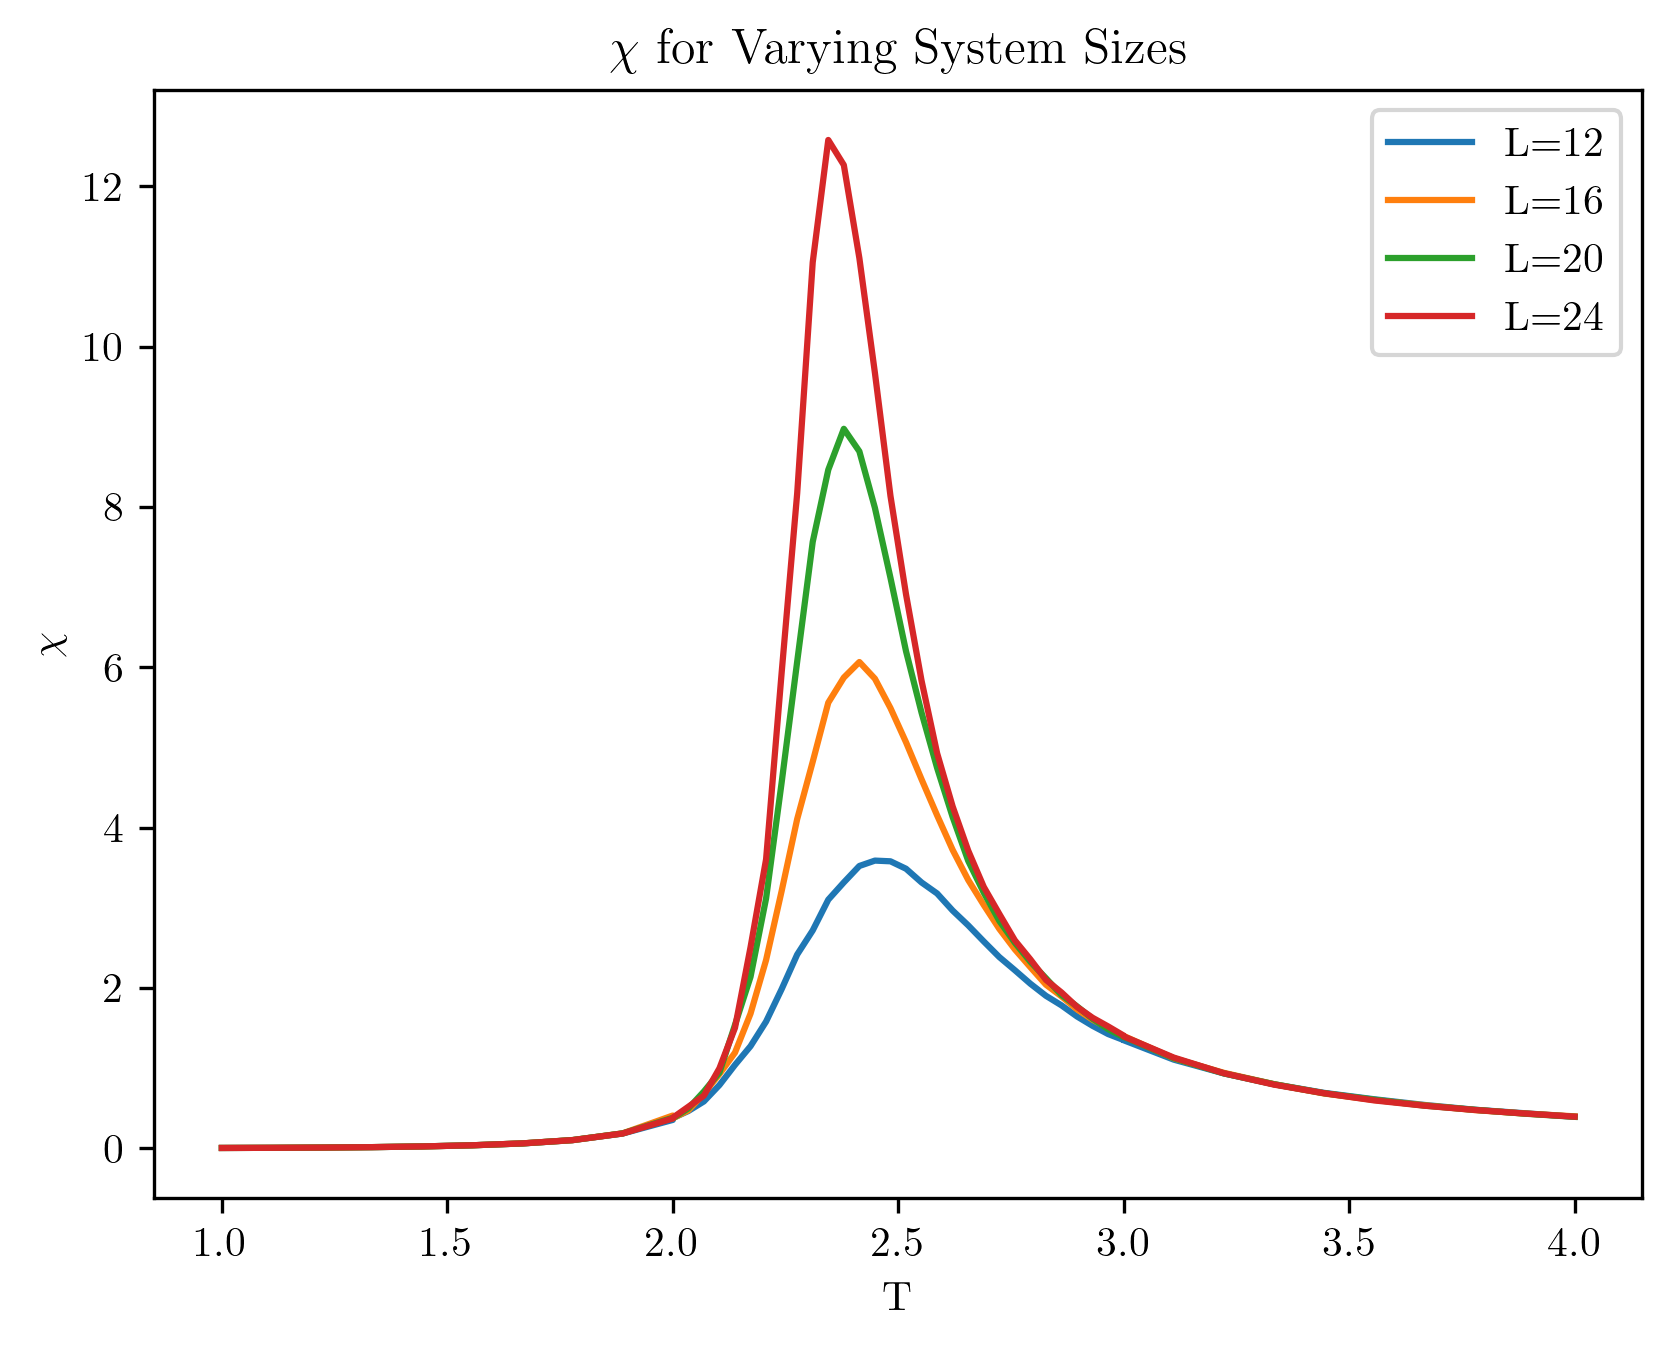

In [101]:
plt.plot(temps, chi12, label='L=12')
plt.plot(temps, chi16, label='L=16')
plt.plot(temps, chi20, label='L=20')
plt.plot(temps, chi24, label='L=24')
plt.title(r'$\chi$ for Varying System Sizes')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.legend()
plt.show()

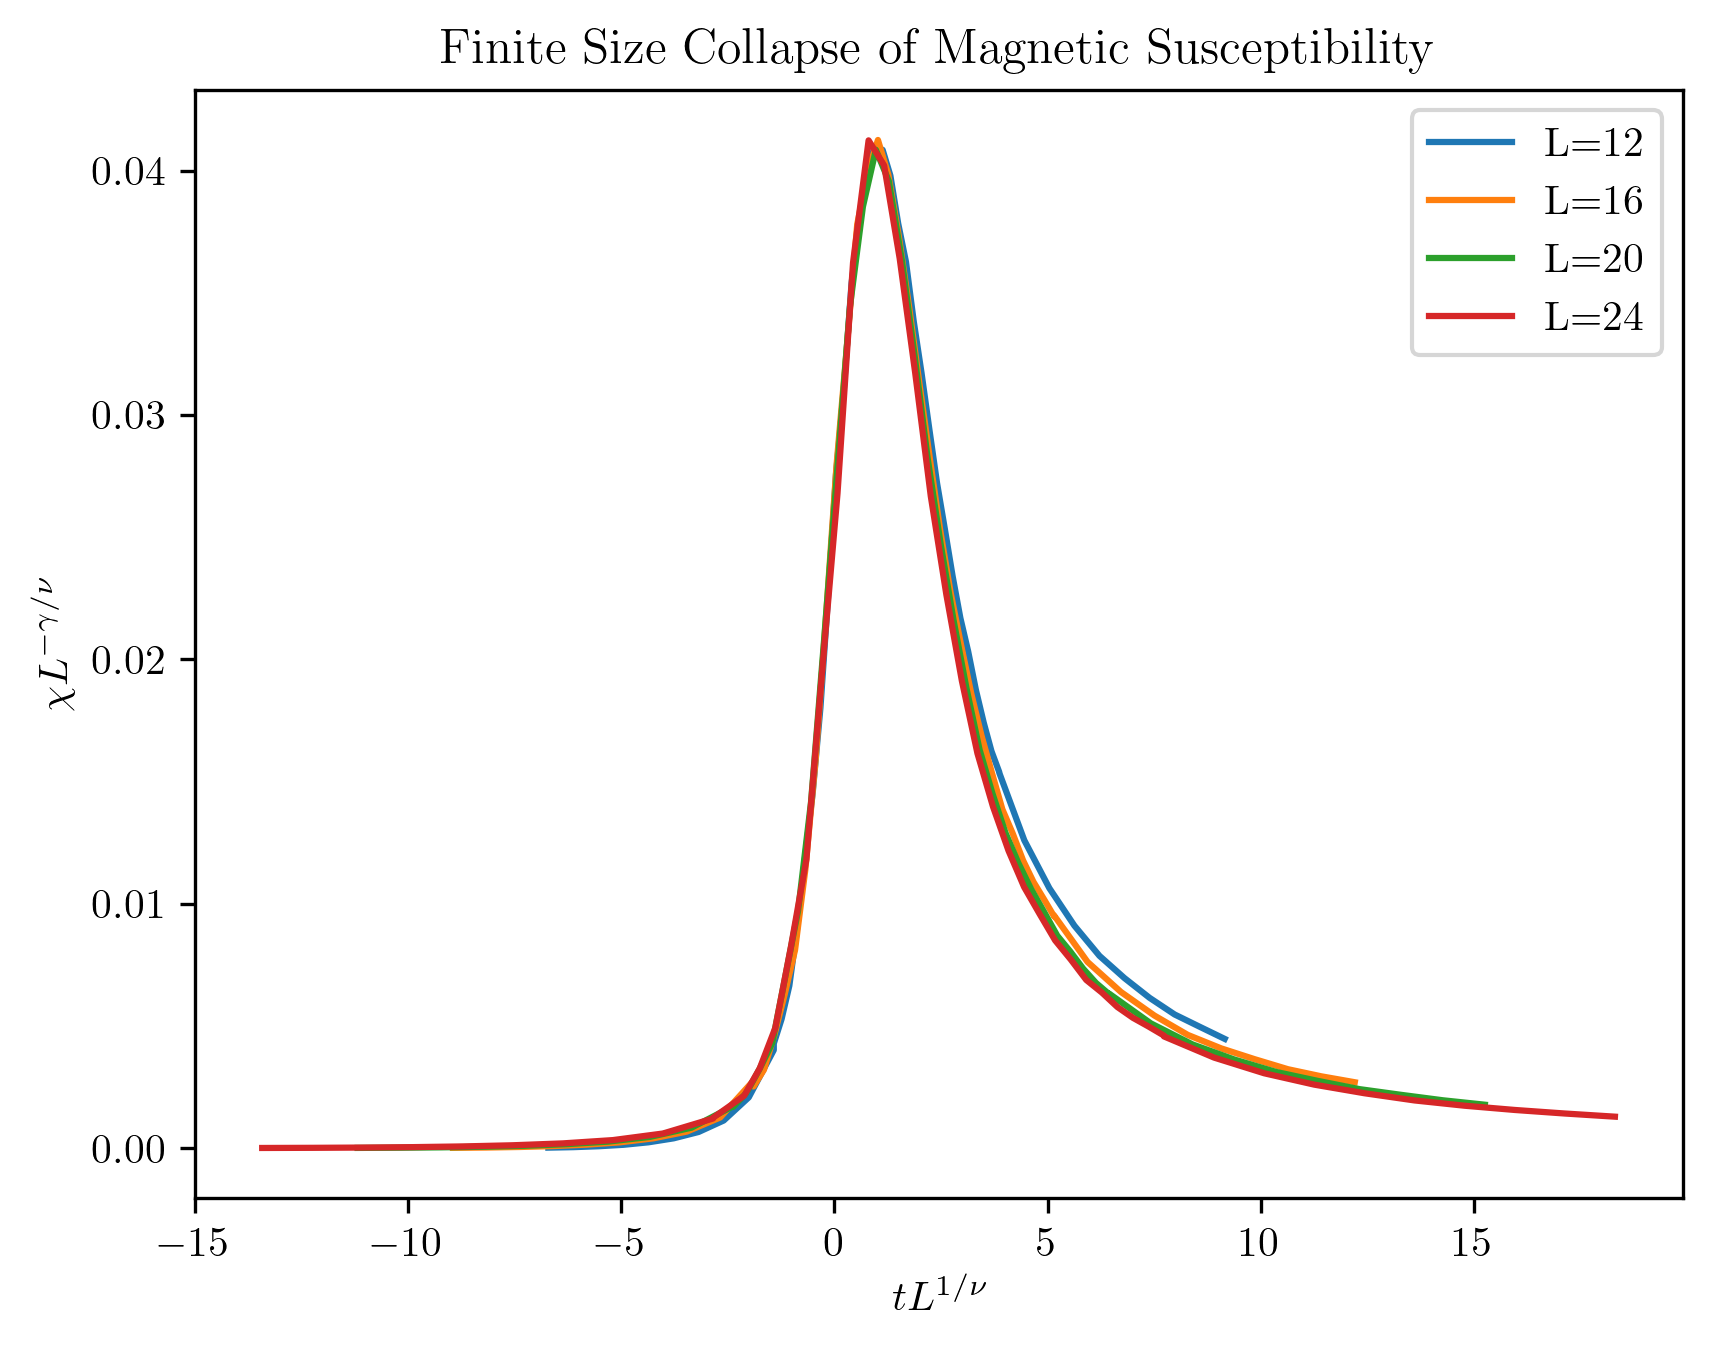

In [129]:
t = (temps-Tc_act)/Tc_act

gamma = 1.8
nu = 1

plt.plot(12**(1/nu)*t, 12**(-gamma/nu)*chi12, label='L=12')
plt.plot(16**(1/nu)*t, 16**(-gamma/nu)*chi16, label='L=16')
plt.plot(20**(1/nu)*t, 20**(-gamma/nu)*chi20, label='L=20')
plt.plot(24**(1/nu)*t, 24**(-gamma/nu)*chi24, label='L=24')
plt.title('Finite Size Collapse of Magnetic Susceptibility')
plt.ylabel(r'$\chi L^{-\gamma/\nu}$')
plt.xlabel(r'$tL^{1/\nu}$')
plt.legend()
plt.show()